In [1]:
pip install "gensim==3.8.1"

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import numpy as np
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/Shareddrives/MADS-Capstone-main/assets/df_train_full_info.csv')

In [5]:
stop_words = stopwords.words('english')
def process_text(text):
  
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    text = tokenizer.tokenize(text)
    text = [i.lower() for i in text]
    text = [re.sub('[0-9]+', '', i) for i in text]
    text = [i for i in text if i not in stop_words]
    text = [i for i in text if len(i)>1]
    text = [i for i in text if ' ' not in i]

    return text

In [6]:
texts = [process_text(i) for i in df.tweet_text]

In [7]:
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 45 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
# best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

scores

[(5, 0.29022),
 (10, 0.32145),
 (15, 0.34299),
 (20, 0.38206),
 (25, 0.42394),
 (30, 0.39551),
 (35, 0.41725),
 (40, 0.41418),
 (45, 0.40763)]

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Coherence Score')

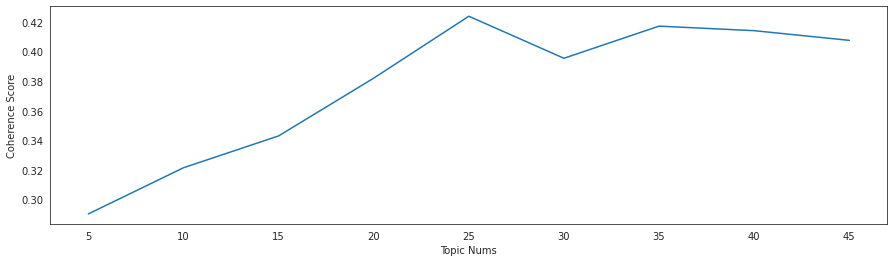

In [17]:
sns.color_palette("hls", 8)
sns.set_style("white")
plt.figure(figsize=(15,4))
sns.lineplot([i[0] for i in scores], [i[1] for i in scores])
plt.xlabel('Topic Nums')
plt.ylabel('Coherence Score')

In [10]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)
tfidf = tfidf_vectorizer.fit_transform(texts)

In [18]:
nmf = NMF(
    n_components=25,
    init='nndsvd'
).fit(tfidf)

In [19]:
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

In [20]:
# Get the residuals for each document
r = np.zeros(A.shape[0])
for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

Text(0, 0.5, 'Residual')

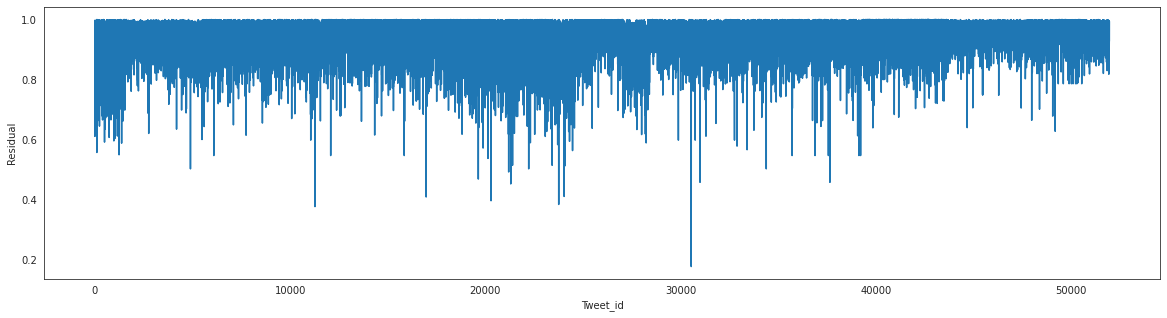

In [21]:
plt.figure(figsize=(20,5))
plt.plot(r)
plt.xlabel('Tweet_id')
plt.ylabel('Residual')